In [1]:
import torch as np
from torchvision.utils import save_image
from torch.utils import data

from tools.celeba import CelebALoader
from dataset import Split

from models2.CSA import CSA
from tools.toml import load_option
from tools.mask import mask_iter

## 数据载入

In [2]:
header_opt = load_option('options/header.toml')
loader = CelebALoader(header_opt.data_root)
dataset = Split(loader, header_opt.fine_size)
train_data = dataset.train('bbox', pil_transform=True, alpha=0.5)
trainset = data.DataLoader(train_data,
                           batch_size=header_opt.batch_size,
                           shuffle=True)
maskset = mask_iter(header_opt.mask_root, header_opt.fine_size)
print('训练集数量：', len(trainset))
print('掩码数量：', len(maskset))

训练集数量： 162770
掩码数量： 12000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


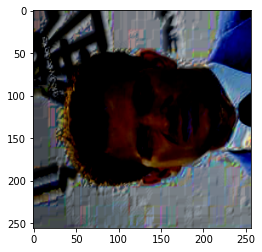

In [3]:
train_data = dataset.train('bbox', pil_transform=True, alpha=0.75)
x = train_data[14][0].transpose(0, 2)

from matplotlib import pyplot as plt
# 查看处理后的图片
plt.imshow(x);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


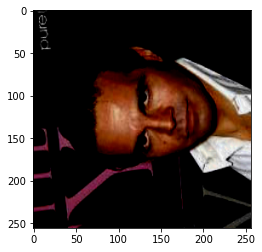

In [4]:
train_data = dataset.train('bbox', pil_transform=True, alpha=0.95)
x = train_data[7][0].transpose(0, 2)

from matplotlib import pyplot as plt
# 查看处理后的图片
plt.imshow(x);

## 模型载入

In [5]:
base_opt = load_option('options/base.toml')
opt = load_option('options/train.toml')
opt.update(base_opt)

model = CSA(**opt)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
---------- Networks initialized -------------
UnetGeneratorCSA(
  (model): UnetSkipConnectionBlock_3(
    (model): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): UnetSkipConnectionBlock_3(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
          (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (6): UnetSkipConnectionBlock_3(
            (model): Sequential(
              (0): LeakyReLU(negat

## 模型训练

In [6]:
import time
from random import randint


def mask_op(mask):
    mask = mask.cuda()
    mask = mask[0][0]
    mask = np.unsqueeze(mask, 0)
    mask = np.unsqueeze(mask, 1)
    mask = mask.byte()
    return mask

In [7]:
# 超参数设定
epochs = 15
display_freq = 1000
save_epoch_freq = 1

image_save_dir = model.save_dir / 'images'
load_epoch = 9
load_alpha = 0.42

In [8]:
if not image_save_dir.exists():
    image_save_dir.mkdir(parents=True, exist_ok=True)

total_steps = 0
iter_start_time = time.time()
# 载入已经训练的模型

if load_epoch:
    model.load(f"{load_epoch}-{load_alpha}")
start_epoch = load_epoch + 1
for epoch in range(start_epoch, epochs):
    epoch_start_time = time.time()
    epoch_iter = 0
    alpha = randint(0, 100)/100 if epoch < epochs-1 else 1
    train_data = dataset.train('bbox', pil_transform=True, alpha=alpha)
    trainset = data.DataLoader(train_data,
                               batch_size=model.batch_size,
                               shuffle=True)
    for batch, mask in zip(trainset, maskset):
        image = batch[0]
        mask = mask_op(mask)
        total_steps += model.batch_size
        epoch_iter += model.batch_size
        # it not only sets the input data with mask, but also sets the latent mask.
        model.set_input(image, mask)
        model.set_gt_latent()
        model.optimize_parameters()
        if total_steps % display_freq == 0:
            real_A, real_B, fake_B = model.get_current_visuals()
            # real_A=input, real_B=ground truth fake_b=output
            pic = (np.cat([real_A, real_B, fake_B], dim=0) + 1) / 2.0
            image_name = f"epoch{epoch}-{total_steps}-{alpha}.jpg"

            save_image(pic, image_save_dir/image_name, nrow=1)
        if total_steps % 100 == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / model.batch_size
            print(
                f"Epoch/total_steps/alpha: {epoch}/{total_steps}/{alpha}", dict(errors))
    if epoch % save_epoch_freq == 0:
        print(f'保存模型 Epoch {epoch}, iters {total_steps} 在 {model.save_dir}')
        model.save(f'{epoch}-{alpha}')
    print(
        f'Epoch/Epochs {epoch}/{epochs-1} 花费时间：{time.time() - epoch_start_time}s')
    model.update_learning_rate()

Epoch/total_steps/alpha: 10/100/0.55 {'G_GAN': 5.217047214508057, 'G_L1': 4.882641315460205, 'D': 1.1768302917480469, 'F': 0.17981675267219543}
Epoch/total_steps/alpha: 10/200/0.55 {'G_GAN': 4.997414588928223, 'G_L1': 3.0683717727661133, 'D': 1.0367867946624756, 'F': 0.0899038016796112}
Epoch/total_steps/alpha: 10/300/0.55 {'G_GAN': 4.5527801513671875, 'G_L1': 6.811295986175537, 'D': 0.9918047189712524, 'F': 0.1901763528585434}
Epoch/total_steps/alpha: 10/400/0.55 {'G_GAN': 5.28938102722168, 'G_L1': 3.945913076400757, 'D': 0.9827999472618103, 'F': 0.08511260896921158}
Epoch/total_steps/alpha: 10/500/0.55 {'G_GAN': 4.956086158752441, 'G_L1': 7.877992153167725, 'D': 1.0423939228057861, 'F': 0.1337316930294037}
Epoch/total_steps/alpha: 10/600/0.55 {'G_GAN': 4.94264030456543, 'G_L1': 6.262046813964844, 'D': 0.9680197834968567, 'F': 0.043969400227069855}
Epoch/total_steps/alpha: 10/700/0.55 {'G_GAN': 4.7998433113098145, 'G_L1': 6.311676025390625, 'D': 1.0430145263671875, 'F': 0.050625503063

Epoch/total_steps/alpha: 10/5800/0.55 {'G_GAN': 6.122021675109863, 'G_L1': 4.72583532333374, 'D': 0.4066110849380493, 'F': 0.007531170733273029}
Epoch/total_steps/alpha: 10/5900/0.55 {'G_GAN': 5.42573356628418, 'G_L1': 5.474781513214111, 'D': 1.033799648284912, 'F': 0.0075292764231562614}
Epoch/total_steps/alpha: 10/6000/0.55 {'G_GAN': 5.74176025390625, 'G_L1': 4.422170639038086, 'D': 0.6084226369857788, 'F': 0.007993606850504875}
Epoch/total_steps/alpha: 10/6100/0.55 {'G_GAN': 5.478634357452393, 'G_L1': 3.002870559692383, 'D': 0.7424906492233276, 'F': 0.009106769226491451}
Epoch/total_steps/alpha: 10/6200/0.55 {'G_GAN': 4.92128324508667, 'G_L1': 8.798924446105957, 'D': 2.2606618404388428, 'F': 0.008256139233708382}
Epoch/total_steps/alpha: 10/6300/0.55 {'G_GAN': 5.630829811096191, 'G_L1': 4.517448425292969, 'D': 0.686437726020813, 'F': 0.019203538075089455}
Epoch/total_steps/alpha: 10/6400/0.55 {'G_GAN': 5.0442304611206055, 'G_L1': 3.8436851501464844, 'D': 1.0634784698486328, 'F': 0.0

Epoch/total_steps/alpha: 10/11500/0.55 {'G_GAN': 5.758558750152588, 'G_L1': 3.6708691120147705, 'D': 0.6185976266860962, 'F': 0.006823362782597542}
Epoch/total_steps/alpha: 10/11600/0.55 {'G_GAN': 5.449018478393555, 'G_L1': 6.926482200622559, 'D': 1.0816633701324463, 'F': 0.012210117653012276}
Epoch/total_steps/alpha: 10/11700/0.55 {'G_GAN': 5.518651962280273, 'G_L1': 6.292430400848389, 'D': 0.8687480688095093, 'F': 0.015967201441526413}
Epoch/total_steps/alpha: 10/11800/0.55 {'G_GAN': 5.437038421630859, 'G_L1': 6.955254077911377, 'D': 1.1529467105865479, 'F': 0.006615009158849716}
Epoch/total_steps/alpha: 10/11900/0.55 {'G_GAN': 5.183145523071289, 'G_L1': 4.988813877105713, 'D': 1.0514187812805176, 'F': 0.01926593855023384}
Epoch/total_steps/alpha: 10/12000/0.55 {'G_GAN': 7.629101753234863, 'G_L1': 5.120303630828857, 'D': 1.5064646005630493, 'F': 0.006938507314771414}
保存模型 Epoch 10, iters 12000 在 ..\checkpoints\CSA
Epoch/Epochs 10/14 花费时间：21184.62861275673s
learning rate = 0.0002
Epoc

Epoch/total_steps/alpha: 11/17000/0.02 {'G_GAN': 7.164231300354004, 'G_L1': 2.517193078994751, 'D': 0.07431952655315399, 'F': 0.02130184881389141}
Epoch/total_steps/alpha: 11/17100/0.02 {'G_GAN': 6.336702823638916, 'G_L1': 5.741675853729248, 'D': 0.414456844329834, 'F': 0.016431637108325958}
Epoch/total_steps/alpha: 11/17200/0.02 {'G_GAN': 5.336187362670898, 'G_L1': 3.507967710494995, 'D': 0.9198510050773621, 'F': 0.01856703869998455}
Epoch/total_steps/alpha: 11/17300/0.02 {'G_GAN': 6.738973140716553, 'G_L1': 5.871975421905518, 'D': 0.27556055784225464, 'F': 0.007975403219461441}
Epoch/total_steps/alpha: 11/17400/0.02 {'G_GAN': 8.441179275512695, 'G_L1': 7.630325794219971, 'D': 0.05814625695347786, 'F': 0.013803836889564991}
Epoch/total_steps/alpha: 11/17500/0.02 {'G_GAN': 5.433943271636963, 'G_L1': 4.73325252532959, 'D': 0.9447834491729736, 'F': 0.02407267317175865}
Epoch/total_steps/alpha: 11/17600/0.02 {'G_GAN': 5.521676063537598, 'G_L1': 2.201568126678467, 'D': 0.6306972503662109, 

Epoch/total_steps/alpha: 11/22600/0.02 {'G_GAN': 7.135030746459961, 'G_L1': 6.05147647857666, 'D': 0.10183245688676834, 'F': 0.02603786811232567}
Epoch/total_steps/alpha: 11/22700/0.02 {'G_GAN': 8.084259986877441, 'G_L1': 16.233259201049805, 'D': 0.1373840570449829, 'F': 0.02149486541748047}
Epoch/total_steps/alpha: 11/22800/0.02 {'G_GAN': 16.37935447692871, 'G_L1': 9.340036392211914, 'D': 1.5889904499053955, 'F': 0.014606214128434658}
Epoch/total_steps/alpha: 11/22900/0.02 {'G_GAN': 5.6266770362854, 'G_L1': 2.3079769611358643, 'D': 0.6196626424789429, 'F': 0.019863072782754898}
Epoch/total_steps/alpha: 11/23000/0.02 {'G_GAN': 6.560585975646973, 'G_L1': 12.526455879211426, 'D': 0.2572826147079468, 'F': 0.014167613349854946}
Epoch/total_steps/alpha: 11/23100/0.02 {'G_GAN': 7.2832770347595215, 'G_L1': 4.901205539703369, 'D': 0.09925408661365509, 'F': 0.020305970683693886}
Epoch/total_steps/alpha: 11/23200/0.02 {'G_GAN': 5.389070987701416, 'G_L1': 1.798373818397522, 'D': 0.79753577709198,

Epoch/total_steps/alpha: 12/28100/0.22 {'G_GAN': 4.762573719024658, 'G_L1': 3.6830761432647705, 'D': 1.5800042152404785, 'F': 0.017105333507061005}
Epoch/total_steps/alpha: 12/28200/0.22 {'G_GAN': 5.3408613204956055, 'G_L1': 2.620596408843994, 'D': 0.8184236288070679, 'F': 0.004888038616627455}
Epoch/total_steps/alpha: 12/28300/0.22 {'G_GAN': 5.013397693634033, 'G_L1': 3.1421775817871094, 'D': 1.226449966430664, 'F': 0.0068516540341079235}
Epoch/total_steps/alpha: 12/28400/0.22 {'G_GAN': 7.987181186676025, 'G_L1': 7.217842102050781, 'D': 0.05916282534599304, 'F': 0.010389477014541626}
Epoch/total_steps/alpha: 12/28500/0.22 {'G_GAN': 5.494723320007324, 'G_L1': 6.848213195800781, 'D': 0.9833817481994629, 'F': 0.0209664236754179}
Epoch/total_steps/alpha: 12/28600/0.22 {'G_GAN': 5.591034889221191, 'G_L1': 10.666335105895996, 'D': 1.0332242250442505, 'F': 0.014672239311039448}
Epoch/total_steps/alpha: 12/28700/0.22 {'G_GAN': 7.189505100250244, 'G_L1': 12.541922569274902, 'D': 0.166522175073

Epoch/total_steps/alpha: 12/33700/0.22 {'G_GAN': 4.971115589141846, 'G_L1': 3.124769449234009, 'D': 1.058974027633667, 'F': 0.012664609588682652}
Epoch/total_steps/alpha: 12/33800/0.22 {'G_GAN': 6.525131702423096, 'G_L1': 6.910260200500488, 'D': 0.2429768443107605, 'F': 0.0044082035310566425}
Epoch/total_steps/alpha: 12/33900/0.22 {'G_GAN': 5.545741081237793, 'G_L1': 3.053786277770996, 'D': 0.6676135659217834, 'F': 0.007010616362094879}
Epoch/total_steps/alpha: 12/34000/0.22 {'G_GAN': 6.113081455230713, 'G_L1': 5.112934112548828, 'D': 0.41783931851387024, 'F': 0.004643736407160759}
Epoch/total_steps/alpha: 12/34100/0.22 {'G_GAN': 10.03872013092041, 'G_L1': 10.19538688659668, 'D': 1.2190111875534058, 'F': 0.004676741547882557}
Epoch/total_steps/alpha: 12/34200/0.22 {'G_GAN': 5.503803253173828, 'G_L1': 3.7858219146728516, 'D': 0.7459428310394287, 'F': 0.0022601052187383175}
Epoch/total_steps/alpha: 12/34300/0.22 {'G_GAN': 6.301305294036865, 'G_L1': 4.58770227432251, 'D': 0.46686375141143

Epoch/total_steps/alpha: 13/39200/0.66 {'G_GAN': 6.000610828399658, 'G_L1': 7.817192554473877, 'D': 0.5442746877670288, 'F': 0.006152595393359661}
Epoch/total_steps/alpha: 13/39300/0.66 {'G_GAN': 5.158076286315918, 'G_L1': 6.189834117889404, 'D': 1.0924079418182373, 'F': 0.007067173719406128}
Epoch/total_steps/alpha: 13/39400/0.66 {'G_GAN': 5.556731700897217, 'G_L1': 6.438870906829834, 'D': 0.7257893085479736, 'F': 0.0038217599503695965}
Epoch/total_steps/alpha: 13/39500/0.66 {'G_GAN': 6.748751640319824, 'G_L1': 7.880353927612305, 'D': 0.27213186025619507, 'F': 0.006433745846152306}
Epoch/total_steps/alpha: 13/39600/0.66 {'G_GAN': 6.318463325500488, 'G_L1': 7.126277923583984, 'D': 0.5033198595046997, 'F': 0.002782477531582117}
Epoch/total_steps/alpha: 13/39700/0.66 {'G_GAN': 5.248764991760254, 'G_L1': 5.551657676696777, 'D': 0.9969462156295776, 'F': 0.007360965013504028}
Epoch/total_steps/alpha: 13/39800/0.66 {'G_GAN': 5.042351722717285, 'G_L1': 3.9714434146881104, 'D': 1.2025135755538

Epoch/total_steps/alpha: 13/44800/0.66 {'G_GAN': 5.69394588470459, 'G_L1': 3.6294453144073486, 'D': 0.6075862050056458, 'F': 0.015691550448536873}
Epoch/total_steps/alpha: 13/44900/0.66 {'G_GAN': 5.674154758453369, 'G_L1': 5.473285675048828, 'D': 0.837253987789154, 'F': 0.005063352175056934}
Epoch/total_steps/alpha: 13/45000/0.66 {'G_GAN': 5.078299522399902, 'G_L1': 4.3631486892700195, 'D': 1.2259142398834229, 'F': 0.00397847592830658}
Epoch/total_steps/alpha: 13/45100/0.66 {'G_GAN': 6.2327070236206055, 'G_L1': 7.585019111633301, 'D': 0.5482722520828247, 'F': 0.011347789317369461}
Epoch/total_steps/alpha: 13/45200/0.66 {'G_GAN': 5.467068195343018, 'G_L1': 4.9973673820495605, 'D': 0.841916561126709, 'F': 0.005197056569159031}
Epoch/total_steps/alpha: 13/45300/0.66 {'G_GAN': 5.392910003662109, 'G_L1': 5.137648582458496, 'D': 0.8552747368812561, 'F': 0.008476195856928825}
Epoch/total_steps/alpha: 13/45400/0.66 {'G_GAN': 5.684959888458252, 'G_L1': 6.474492073059082, 'D': 0.7458146810531616

Epoch/total_steps/alpha: 14/50400/1 {'G_GAN': 4.7995500564575195, 'G_L1': 7.433967113494873, 'D': 1.7007039785385132, 'F': 0.0025981313083320856}
Epoch/total_steps/alpha: 14/50500/1 {'G_GAN': 5.587765693664551, 'G_L1': 10.025527000427246, 'D': 1.48797607421875, 'F': 0.012510925531387329}
Epoch/total_steps/alpha: 14/50600/1 {'G_GAN': 4.978643417358398, 'G_L1': 6.350897789001465, 'D': 1.5787349939346313, 'F': 0.004167600069195032}
Epoch/total_steps/alpha: 14/50700/1 {'G_GAN': 5.707395076751709, 'G_L1': 8.9226713180542, 'D': 0.8850274085998535, 'F': 0.001666670897975564}
Epoch/total_steps/alpha: 14/50800/1 {'G_GAN': 5.6631669998168945, 'G_L1': 8.639028549194336, 'D': 0.7512916326522827, 'F': 0.007516441401094198}
Epoch/total_steps/alpha: 14/50900/1 {'G_GAN': 6.977268218994141, 'G_L1': 8.018549919128418, 'D': 0.15808022022247314, 'F': 0.010329589247703552}
Epoch/total_steps/alpha: 14/51000/1 {'G_GAN': 5.901273727416992, 'G_L1': 8.554471969604492, 'D': 0.7418650388717651, 'F': 0.00299884472

Epoch/total_steps/alpha: 14/56100/1 {'G_GAN': 6.665361404418945, 'G_L1': 7.555875778198242, 'D': 0.35303300619125366, 'F': 0.008376850746572018}
Epoch/total_steps/alpha: 14/56200/1 {'G_GAN': 5.2220458984375, 'G_L1': 9.59022045135498, 'D': 1.8351494073867798, 'F': 0.008127165026962757}
Epoch/total_steps/alpha: 14/56300/1 {'G_GAN': 6.555189609527588, 'G_L1': 11.06155776977539, 'D': 0.3752683997154236, 'F': 0.004194212611764669}
Epoch/total_steps/alpha: 14/56400/1 {'G_GAN': 5.420528411865234, 'G_L1': 10.867505073547363, 'D': 1.28599214553833, 'F': 0.013310756534337997}
Epoch/total_steps/alpha: 14/56500/1 {'G_GAN': 7.212606430053711, 'G_L1': 9.108193397521973, 'D': 0.20491193234920502, 'F': 0.0048820809461176395}
Epoch/total_steps/alpha: 14/56600/1 {'G_GAN': 7.2757978439331055, 'G_L1': 8.901911735534668, 'D': 0.2265537828207016, 'F': 0.003890891093760729}
Epoch/total_steps/alpha: 14/56700/1 {'G_GAN': 6.1003851890563965, 'G_L1': 8.61534309387207, 'D': 0.8771235942840576, 'F': 0.002969627268